## Imports

In [1]:
import librosa

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random

from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import torch
import torchmetrics
import os

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Config

In [2]:
class Config:
    SR = 32000
    N_MFCC = 80
    # Dataset
    ROOT_FOLDER = './'
    # Training
    N_CLASSES = 2
    BATCH_SIZE = 96
    N_EPOCHS = 10
    LR = 3e-4
    # Others
    SEED = 42

CONFIG = Config()

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CONFIG.SEED) # Seed 고정

In [ ]:
df = pd.read_csv('open/train.csv')
train, val, _, _ = train_test_split(df, df['label'], test_size=0.2, random_state=CONFIG.SEED)

## Data Pre-processing : MFCC

In [ ]:
max_train_samples = 40000
max_val_samples = 10000

def get_mfcc_feature(df, max_num, train_mode=True):
    features = []
    labels = []
    iter_num = 0
    for _, row in tqdm(df.iterrows()):
        # librosa패키지를 사용하여 wav 파일 load
        if iter_num >= max_num:
          break
        iter_num += 1
        
        path = 'open/' + row['path'][2:]

        y, sr = librosa.load(path, sr=CONFIG.SR)

        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CONFIG.N_MFCC)
        
        if mfcc.shape[1] < 500:
            pad_width = 500 - mfcc.shape[1]
            pad_value = np.mean(mfcc, axis=1, keepdims=True)
            pad_array = np.tile(pad_value, (1, pad_width))  # 패딩할 행 생성
            mfcc = np.hstack((mfcc, pad_array))  # 패딩 추가
        else:
            mfcc = mfcc[0:80,0:500]
        
        mfcc = np.expand_dims(mfcc, axis = 0)
        features.append(mfcc)

        if train_mode:
            label = row['label']
#             label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
#             label_vector[0 if label == 'fake' else 1] = 1
            label_vector = np.zeros(1, dtype = float)
            if label == 'real':
                label_vector[0] = 0
            else:
                label_vector[0] = 1
#             label_vector[0] = (0 if label == 'fake' else 1)
            labels.append(label_vector)

    if train_mode:
        return features, labels
    return features

train_mfcc, train_labels = get_mfcc_feature(train, max_train_samples, True)
val_mfcc, val_labels = get_mfcc_feature(val, max_val_samples, True)

40000it [19:35, 34.02it/s]
10000it [09:02, 18.43it/s]


In [6]:
# TEST용

In [7]:
print(train_labels)

[array([1.]), array([1.]), array([0.]), array([1.]), array([0.]), array([0.]), array([1.]), array([1.]), array([1.]), array([1.]), array([0.]), array([1.]), array([0.]), array([1.]), array([0.]), array([0.]), array([0.]), array([1.]), array([0.]), array([0.]), array([0.]), array([0.]), array([1.]), array([0.]), array([1.]), array([1.]), array([0.]), array([1.]), array([0.]), array([0.]), array([0.]), array([0.]), array([1.]), array([1.]), array([0.]), array([0.]), array([1.]), array([0.]), array([0.]), array([1.]), array([1.]), array([1.]), array([1.]), array([0.]), array([0.]), array([1.]), array([1.]), array([1.]), array([0.]), array([0.]), array([1.]), array([0.]), array([0.]), array([0.]), array([1.]), array([0.]), array([1.]), array([0.]), array([1.]), array([1.]), array([1.]), array([0.]), array([0.]), array([1.]), array([1.]), array([0.]), array([0.]), array([1.]), array([1.]), array([1.]), array([1.]), array([1.]), array([0.]), array([0.]), array([1.]), array([1.]), array([1.])

In [ ]:
# df = pd.read_csv('open/train.csv')

# train, temp, _, _ = train_test_split(df, df['label'], test_size=0.6, random_state=CONFIG.SEED)
# val, test, _, _ = train_test_split(temp, temp['label'], test_size=5/6, random_state=CONFIG.SEED)

In [9]:
# max_train_samples = 4000
# max_val_samples = 1000
# max_test_samples = 5000

# def get_mfcc_feature(df, max_num, train_mode=True):
#     features = []
#     labels = []
#     iter_num = 0
#     for _, row in tqdm(df.iterrows()):
#         # librosa패키지를 사용하여 wav 파일 load
#         if iter_num >= max_num:
#           break
#         iter_num += 1
        
#         path = 'open/' + row['path'][2:]

#         y, sr = librosa.load(path, sr=CONFIG.SR)

#         # librosa패키지를 사용하여 mfcc 추출
#         mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CONFIG.N_MFCC)
        
#         if mfcc.shape[1] < 400:
#             pad_width = 400 - mfcc.shape[1]
#             pad_value = np.mean(mfcc, axis=1, keepdims=True)
#             pad_array = np.tile(pad_value, (1, pad_width))  # 패딩할 행 생성
#             mfcc = np.hstack((mfcc, pad_array))  # 패딩 추가
#         else:
#             mfcc = mfcc[0:80,0:400]
        
#         mfcc = np.expand_dims(mfcc, axis = 0)
#         features.append(mfcc)

#         if train_mode:
#             label = row['label']
# #             label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
# #             label_vector[0 if label == 'fake' else 1] = 1
#             label_vector = np.zeros(1, dtype = float)
#             label_vector[0] = (0 if label == 'fake' else 1)
#             labels.append(label_vector)

#     if train_mode:
#         return features, labels
#     return features

# train_mfcc, train_labels = get_mfcc_feature(train, max_train_samples, True)
# val_mfcc, val_labels = get_mfcc_feature(val, max_val_samples, True)
# test_mfcc, test_labels = get_mfcc_feature(test, max_test_samples, True)

In [10]:
# class CustomDataset(Dataset):
#     def __init__(self, mfcc, label):
#         self.mfcc = mfcc
#         self.label = label

#     def __len__(self):
#         return len(self.mfcc)

#     def __getitem__(self, index):
#         if self.label is not None:
#             return self.mfcc[index], self.label[index]
#         return self.mfcc[index]

# train_dataset = CustomDataset(train_mfcc, train_labels)
# val_dataset = CustomDataset(val_mfcc, val_labels)
# test_dataset = CustomDataset(test_mfcc, test_labels)

In [11]:
# train_loader = DataLoader(
#     train_dataset,
#     batch_size=CONFIG.BATCH_SIZE,
#     shuffle=True
# )
# val_loader = DataLoader(
#     val_dataset,
#     batch_size=CONFIG.BATCH_SIZE,
#     shuffle=False
# )
# test_loader = DataLoader(
#     test_dataset,
#     batch_size=CONFIG.BATCH_SIZE,
#     shuffle=False
# )

## Dataset

In [12]:
class CustomDataset(Dataset):
    def __init__(self, mfcc, label):
        self.mfcc = mfcc
        self.label = label

    def __len__(self):
        return len(self.mfcc)

    def __getitem__(self, index):
        if self.label is not None:
            return self.mfcc[index], self.label[index]
        return self.mfcc[index]

train_dataset = CustomDataset(train_mfcc, train_labels)
val_dataset = CustomDataset(val_mfcc, val_labels)

In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=False
)

In [14]:
# from typing import Dict

# def get_specrnet_config(input_channels: int) -> Dict:
#     return {
#         "filts": [input_channels, [input_channels, 20], [20, 64], [64, 64]],
#         "nb_fc_node": 64,
#         "gru_node": 64,
#         "nb_gru_layer": 2,
#         "nb_classes": 1,
#     }

## Define Model

In [15]:
class Residual_block2D(nn.Module):
    def __init__(self, nb_filts, first=False):
        super().__init__()
        self.first = first

        if not self.first:
            self.bn1 = nn.BatchNorm2d(num_features=nb_filts[0])

        self.lrelu = nn.LeakyReLU(negative_slope=0.3)

        self.conv1 = nn.Conv2d(
            in_channels=nb_filts[0],
            out_channels=nb_filts[1],
            kernel_size=3,
            padding=1,
            stride=1,
        )

        self.bn2 = nn.BatchNorm2d(num_features=nb_filts[1])
        self.conv2 = nn.Conv2d(
            in_channels=nb_filts[1],
            out_channels=nb_filts[1],
            padding=1,
            kernel_size=3,
            stride=1,
        )

        if nb_filts[0] != nb_filts[1]:
            self.downsample = True
            self.conv_downsample = nn.Conv2d(
                in_channels=nb_filts[0],
                out_channels=nb_filts[1],
                padding=0,
                kernel_size=1,
                stride=1,
            )

        else:
            self.downsample = False
        self.mp = nn.MaxPool2d(2)

    def forward(self, x):
        identity = x
        if not self.first:
            out = self.bn1(x)
            out = self.lrelu(out)
        else:
            out = x

        out = self.conv1(x)
        out = self.bn2(out)
        out = self.lrelu(out)
        out = self.conv2(out)

        if self.downsample:
            identity = self.conv_downsample(identity)

        out += identity
        out = self.mp(out)
        return out


class SpecRNet(nn.Module):
    def __init__(self, d_args, **kwargs):
        super().__init__()

        self.device = kwargs.get("device", "cpu")

        self.first_bn = nn.BatchNorm2d(num_features=d_args["filts"][0])
        self.selu = nn.SELU(inplace=True)
        self.block0 = nn.Sequential(
            Residual_block2D(nb_filts=d_args["filts"][1], first=True)
        )
        self.block2 = nn.Sequential(Residual_block2D(nb_filts=d_args["filts"][2]))
        d_args["filts"][2][0] = d_args["filts"][2][1]
        self.block4 = nn.Sequential(Residual_block2D(nb_filts=d_args["filts"][2]))
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.fc_attention0 = self._make_attention_fc(
            in_features=d_args["filts"][1][-1], l_out_features=d_args["filts"][1][-1]
        )
        self.fc_attention2 = self._make_attention_fc(
            in_features=d_args["filts"][2][-1], l_out_features=d_args["filts"][2][-1]
        )
        self.fc_attention4 = self._make_attention_fc(
            in_features=d_args["filts"][2][-1], l_out_features=d_args["filts"][2][-1]
        )

        self.bn_before_gru = nn.BatchNorm2d(num_features=d_args["filts"][2][-1])
        self.gru = nn.GRU(
            input_size=d_args["filts"][2][-1],
            hidden_size=d_args["gru_node"],
            num_layers=d_args["nb_gru_layer"],
            batch_first=True,
            bidirectional=True,
        )

        self.fc1_gru = nn.Linear(
            in_features=d_args["gru_node"] * 2, out_features=d_args["nb_fc_node"] * 2
        )

        self.fc2_gru = nn.Linear(
            in_features=d_args["nb_fc_node"] * 2,
            out_features=d_args["nb_classes"],
            bias=True,
        )

        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.first_bn(x)
        x = self.selu(x)

        x0 = self.block0(x)
        y0 = self.avgpool(x0).view(x0.size(0), -1)
        y0 = self.fc_attention0(y0)
        y0 = self.sig(y0).view(y0.size(0), y0.size(1), -1)
        y0 = y0.unsqueeze(-1)
        x = x0 * y0 + y0

        x = nn.MaxPool2d(2)(x)

        x2 = self.block2(x)
        y2 = self.avgpool(x2).view(x2.size(0), -1)
        y2 = self.fc_attention2(y2)
        y2 = self.sig(y2).view(y2.size(0), y2.size(1), -1)
        y2 = y2.unsqueeze(-1)
        x = x2 * y2 + y2

        x = nn.MaxPool2d(2)(x)

        x4 = self.block4(x)
        y4 = self.avgpool(x4).view(x4.size(0), -1)
        y4 = self.fc_attention4(y4)
        y4 = self.sig(y4).view(y4.size(0), y4.size(1), -1)
        y4 = y4.unsqueeze(-1)
        x = x4 * y4 + y4

        x = nn.MaxPool2d(2)(x)

        x = self.bn_before_gru(x)
        x = self.selu(x)
        x = x.squeeze(-2)
        x = x.permute(0, 2, 1)
        self.gru.flatten_parameters()
        x, _ = self.gru(x)
        x = x[:, -1, :]
        x = self.fc1_gru(x)
        x = self.fc2_gru(x)
        
        x = torch.sigmoid(x)
        
        return x

    def _make_attention_fc(self, in_features, l_out_features):
        l_fc = []
        l_fc.append(nn.Linear(in_features=in_features, out_features=l_out_features))
        return nn.Sequential(*l_fc)

## Train & Validation

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score

def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.BCELoss().to(device)

    best_auc_score = 0
    best_acc_score = 0
    best_model = None

    for epoch in range(1, CONFIG.N_EPOCHS+1):
        model.train()
        train_loss = []
        for features, labels in tqdm(iter(train_loader)):
            features = features.float().to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            
            output = model(features)
            
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        _val_loss, _val_auc_score, _val_acc_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val AUC : [{_val_auc_score:.5f}] VAL ACC : [{_val_acc_score:.5f}]')

        if ((best_auc_score < _val_auc_score) & (best_acc_score < _val_acc_score)):
            best_auc_score = _val_auc_score
            best_acc_score = _val_acc_score
            best_model = model
        elif ((best_acc_score < _val_acc_score) & ((best_auc_score - _val_auc_score) < 0.02)):
            best_auc_score = _val_auc_score
            best_acc_score = _val_acc_score
            best_model = model
        elif ((best_auc_score + best_acc_score) < (_val_auc_score + _val_acc_score)) :
            best_auc_score = _val_auc_score
            best_acc_score = _val_acc_score
            best_model = model
    return best_model
            
def multiLabel_AUC(y_true, y_scores):
    auc_scores = []
    for i in range(y_true.shape[1]):
        pred_class = np.where(y_scores > 0.5, 1 , 0)
        print(pred_class)
        acc_score = accuracy_score(y_true, pred_class)
        FPRs, TPRs, Thresholds = roc_curve(y_true, y_scores)
        plt.plot(FPRs, TPRs, label = 'ROC')
        plt.plot([0,1],[0,1],'--',label = '0.5')
        plt.legend()
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.show()
        auc = roc_auc_score(y_true[:, i], y_scores[:, i])
        auc_scores.append(auc)
    mean_auc_score = np.mean(auc_scores)
    return mean_auc_score, acc_score

def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for features, labels in tqdm(iter(val_loader)):
            features = features.float().to(device)
            labels = labels.float().to(device)

            probs = model(features)
            loss = criterion(probs, labels)

            val_loss.append(loss.item())

            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

        _val_loss = np.mean(val_loss)

        all_labels = np.concatenate(all_labels, axis=0)
        all_probs = np.concatenate(all_probs, axis=0)

        # Calculate AUC score
        auc_score, acc_score = multiLabel_AUC(all_labels, all_probs)

    return _val_loss, auc_score, acc_score

## Run

100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [03:38<00:00,  2.08s/it]


[[0]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


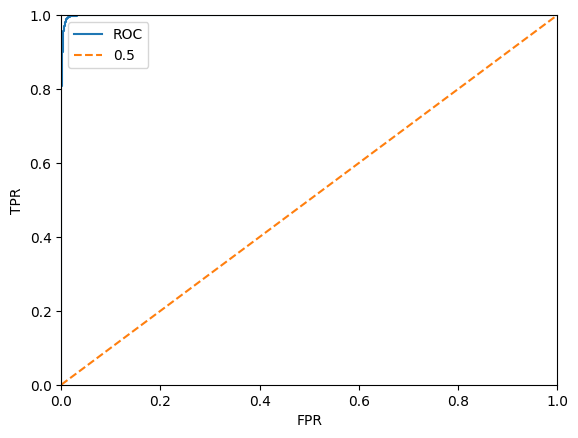

Epoch [1], Train Loss : [0.08713] Val Loss : [0.18713] Val AUC : [0.99920] VAL ACC : [0.93340]


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [03:47<00:00,  2.16s/it]


[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]


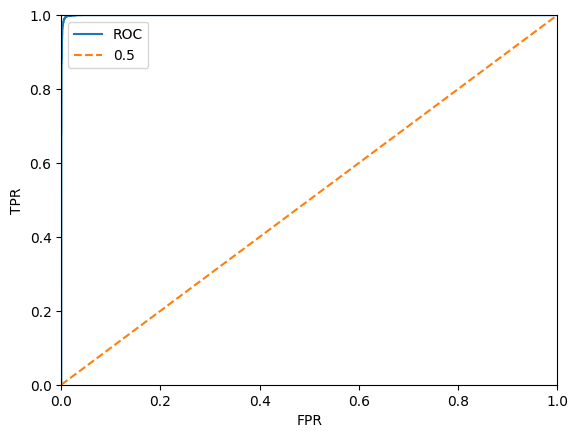

Epoch [2], Train Loss : [0.01953] Val Loss : [0.20177] Val AUC : [0.99950] VAL ACC : [0.93370]


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [03:39<00:00,  2.09s/it]

[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]


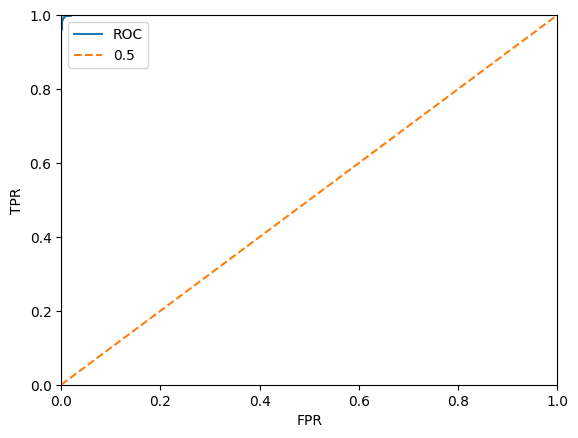

Epoch [3], Train Loss : [0.01088] Val Loss : [0.03112] Val AUC : [0.99981] VAL ACC : [0.98980]


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [03:54<00:00,  2.23s/it]


[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]


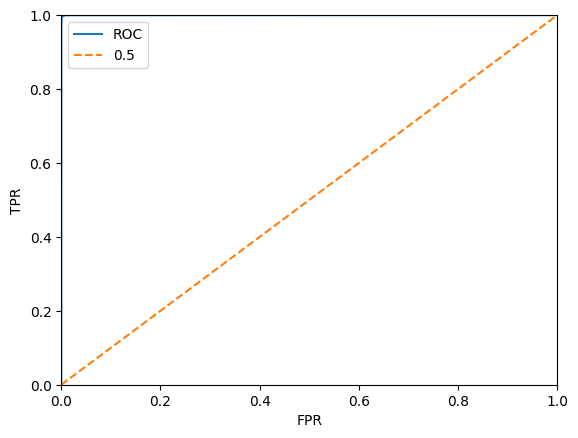

Epoch [4], Train Loss : [0.00863] Val Loss : [0.00799] Val AUC : [0.99997] VAL ACC : [0.99710]


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [03:40<00:00,  2.10s/it]


[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]


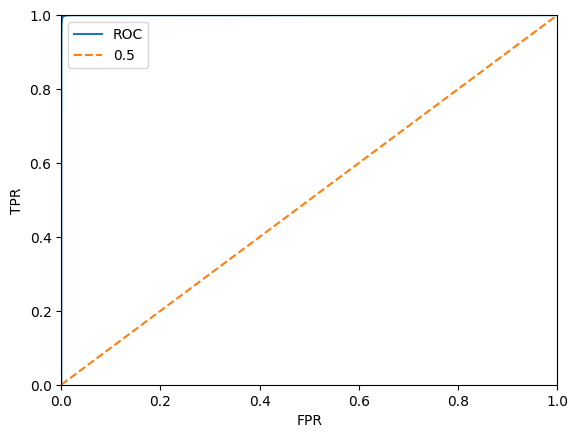

Epoch [5], Train Loss : [0.00762] Val Loss : [0.01294] Val AUC : [0.99992] VAL ACC : [0.99590]


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [03:39<00:00,  2.09s/it]

[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]


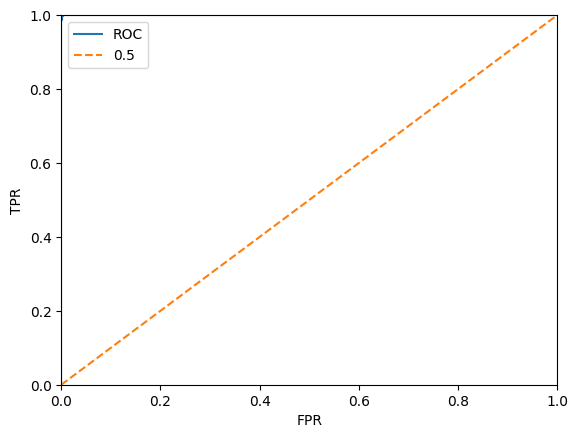

Epoch [6], Train Loss : [0.00461] Val Loss : [0.00845] Val AUC : [0.99997] VAL ACC : [0.99740]


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [03:38<00:00,  2.08s/it]


[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]


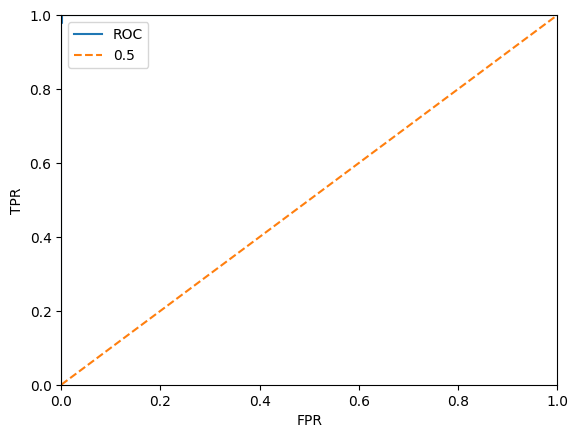

Epoch [7], Train Loss : [0.00461] Val Loss : [0.01877] Val AUC : [0.99997] VAL ACC : [0.99340]


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [03:38<00:00,  2.08s/it]


[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]


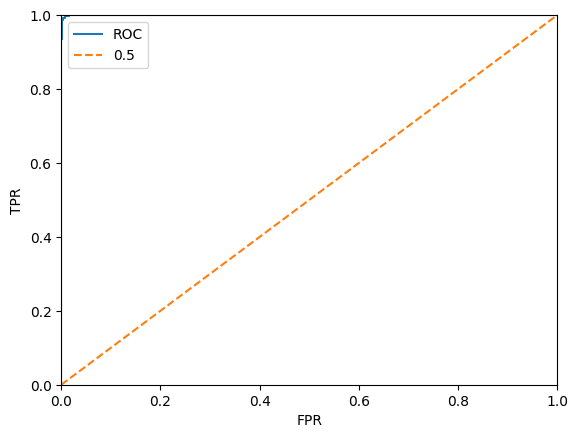

Epoch [8], Train Loss : [0.00425] Val Loss : [0.05557] Val AUC : [0.99979] VAL ACC : [0.98120]


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [03:36<00:00,  2.06s/it]


[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]


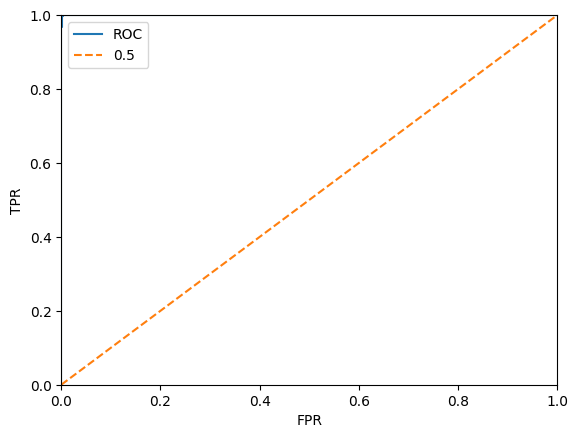

Epoch [9], Train Loss : [0.00347] Val Loss : [0.01075] Val AUC : [0.99996] VAL ACC : [0.99610]


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [03:39<00:00,  2.09s/it]


[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]


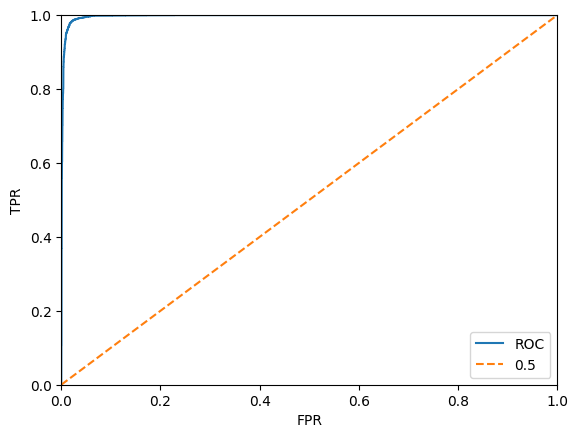

Epoch [10], Train Loss : [0.00292] Val Loss : [0.08481] Val AUC : [0.99705] VAL ACC : [0.97210]


In [17]:
specrnet_variable = {
        "filts": [1, [1, 20], [20, 64], [64, 64]],
        "nb_fc_node": 64,
        "gru_node": 64,
        "nb_gru_layer": 2,
        "nb_classes": 1,
    }

model = SpecRNet(specrnet_variable, device=device)
optimizer = torch.optim.Adam(params = model.parameters(), lr = CONFIG.LR)

infer_model = train(model, optimizer, train_loader, val_loader, device)

In [18]:
# criterion = nn.BCELoss().to(device)

# _test_loss, _test_score = validation(infer_model, criterion, test_loader, device)

In [29]:
print(val_labels)

[array([0.]), array([1.]), array([1.]), array([0.]), array([0.]), array([1.]), array([0.]), array([1.]), array([1.]), array([0.]), array([1.]), array([1.]), array([0.]), array([1.]), array([0.]), array([1.]), array([0.]), array([1.]), array([0.]), array([1.]), array([1.]), array([1.]), array([0.]), array([1.]), array([0.]), array([1.]), array([1.]), array([1.]), array([1.]), array([1.]), array([0.]), array([1.]), array([1.]), array([0.]), array([0.]), array([1.]), array([1.]), array([0.]), array([1.]), array([1.]), array([1.]), array([1.]), array([0.]), array([0.]), array([0.]), array([1.]), array([1.]), array([1.]), array([1.]), array([1.]), array([1.]), array([1.]), array([0.]), array([0.]), array([1.]), array([1.]), array([1.]), array([0.]), array([0.]), array([1.]), array([1.]), array([0.]), array([1.]), array([1.]), array([1.]), array([0.]), array([1.]), array([1.]), array([1.]), array([1.]), array([1.]), array([0.]), array([1.]), array([0.]), array([0.]), array([1.]), array([1.])

In [19]:
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
import pandas as pd

## Inference

In [20]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for features in tqdm(iter(test_loader)):
            features = features.float().to(device)
            
            probs = model(features)

            probs  = probs.cpu().detach().numpy()
            predictions += probs.tolist()
    return predictions

In [ ]:
# test_size: 전체 train.csv 중 test에 사용할 행 비율
test = pd.read_csv('open/test.csv')

test_mfcc = get_mfcc_feature(test,50000, False)
test_dataset = CustomDataset(test_mfcc, None)
test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=False
)

preds = inference(infer_model, test_loader, device)

50000it [1:23:26,  9.99it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 521/521 [19:20<00:00,  2.23s/it]


In [22]:
threshold = 0.5
print(preds)
preds = np.array(preds)
data = (preds > threshold).astype(int)
new_data = []
# for d in data:
#     if d == 0:
#         new_data.append([1, 0])
#     else:
#         new_data.append([0, 1])

for p in preds:
    new_data.append([1-p,p])

new_data = np.array(new_data)
print(new_data)

new_data = new_data.squeeze(2)

print(new_data.shape)

[[0.023698974400758743], [4.9718426453182474e-05], [0.0004096850170753896], [0.8767855167388916], [0.008330419659614563], [1.0148846740776207e-05], [0.3522768020629883], [0.0095205157995224], [0.00014770784764550626], [0.012638657353818417], [0.002535157138481736], [0.8172762989997864], [0.0029001187067478895], [0.00013500898785423487], [0.014339935034513474], [2.013480116147548e-05], [1.3941311408416368e-05], [0.9993108510971069], [0.00253537530079484], [0.004350826144218445], [0.004352952353656292], [0.00010576437489362434], [0.9986604452133179], [0.13510608673095703], [0.0026116748340427876], [0.20522870123386383], [0.0010099279461428523], [0.0001708219642750919], [0.009492865763604641], [0.0004258695407770574], [5.7852557802107185e-05], [2.575867620180361e-05], [0.022191153839230537], [0.0012149411486461759], [0.04835101217031479], [0.0009308489970862865], [0.0001599273382453248], [0.0003998813626822084], [0.0014745824737474322], [0.0019095925381407142], [0.0001403733913321048], [0

[[[9.76301026e-01]
  [2.36989744e-02]]

 [[9.99950282e-01]
  [4.97184265e-05]]

 [[9.99590315e-01]
  [4.09685017e-04]]

 ...

 [[9.99865022e-01]
  [1.34977701e-04]]

 [[9.99474073e-01]
  [5.25926589e-04]]

 [[9.98823767e-01]
  [1.17623259e-03]]]
(50000, 2)


In [ ]:
submit = pd.DataFrame(new_data, columns=['fake', 'real'])

# 결과 출력 및 CSV 파일로 저장
print(submit.head())
submit.to_csv('open/submit_SpecRNet.csv', index=False)

In [ ]:
test = pd.read_csv('open/test.csv')

index_id = test.iloc[:,0]

submit = pd.DataFrame(new_data, index = index_id, columns=['fake', 'real'])

# 결과 출력 및 CSV 파일로 저장
print(submit.head())
submit.to_csv('open/submit_SpecRNet.csv', index=True)

## Calibrate

In [25]:
def expected_calibration_error(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    bin_totals = np.histogram(y_prob, bins=np.linspace(0, 1, n_bins + 1), density=False)[0]
    non_empty_bins = bin_totals > 0
    bin_weights = bin_totals / len(y_prob)
    bin_weights = bin_weights[non_empty_bins]
    prob_true = prob_true[:len(bin_weights)]
    prob_pred = prob_pred[:len(bin_weights)]
    ece = np.sum(bin_weights * np.abs(prob_true - prob_pred))
    return ece

In [26]:
def auc_brier_ece(answer_df, submission_df):
    # Check for missing values in submission_df
    if submission_df.isnull().values.any():
        raise ValueError("The submission dataframe contains missing values.")


    # Check if the number and names of columns are the same in both dataframes
    if len(answer_df.columns) != len(submission_df.columns) or not all(answer_df.columns == submission_df.columns):
        raise ValueError("The columns of the answer and submission dataframes do not match.")

    submission_df = submission_df[submission_df.iloc[:, 0].isin(answer_df.iloc[:, 0])]
    submission_df.index = range(submission_df.shape[0])

    # Calculate AUC for each class
    auc_scores = []
    for column in answer_df.columns[1:]:
        y_true = answer_df[column]
        y_scores = submission_df[column]
        auc = roc_auc_score(y_true, y_scores)
        auc_scores.append(auc)


    # Calculate mean AUC
    mean_auc = np.mean(auc_scores)


    brier_scores = []
    ece_scores = []

    # Calculate Brier Score and ECE for each class
    for column in answer_df.columns[1:]:
        y_true = answer_df[column].values
        y_prob = submission_df[column].values

        # Brier Score
        brier = mean_squared_error(y_true, y_prob)
        brier_scores.append(brier)

        # ECE
        ece = expected_calibration_error(y_true, y_prob)
        ece_scores.append(ece)

    # Calculate mean Brier Score and mean ECE
    mean_brier = np.mean(brier_scores)
    mean_ece = np.mean(ece_scores)

    # Calculate combined score
    combined_score = 0.5 * (1 - mean_auc) + 0.25 * mean_brier + 0.25 * mean_ece

    return combined_score

In [ ]:
import pandas as pd

# test와 submission.csv 의 dataframe 읽기
test_df = test

submission_csv_path = 'open/submit_SpecRNet.csv' # 여기에 submission.csv 경로 또는 dataframe 변수이름 입력해주세요
submission_df = pd.read_csv(submission_csv_path)

# 새로운 DataFrame 생성
answer_df = pd.DataFrame()
test_answer = pd.read_csv('open/test_answer.csv')

if test_df.shape[0] != submission_df.shape[0]:
  print("test와 submission dataframe의 행 수가 다릅니다.")
  print(f"test 행 수: {test_df.shape[0]}")
  print(f"submission_df 행 수: {submission_df.shape[0]}")

else:
  # 첫 번째 열은 submission.csv의 'id'와 동일: 동일 해야 평가 함수 사용 가능
  #answer_df['id'] = submission_df['id']

  # 두 번째 열은 'label'이 'fake'일 때 1, 아니면 0
  answer_df['fake'] = test_answer['label'].apply(lambda x: 1 if x == 'fake' else (0 if pd.notna(x) else np.nan))

  # 세 번째 열은 'label'이 'real'일 때 1, 아니면 0
  answer_df['real'] = test_answer['label'].apply(lambda x: 1 if x == 'real' else (0 if pd.notna(x) else np.nan))

  # 변환된 DataFrame을 새로운 CSV 파일로 저장합니다.
  answer_csv_path = 'open/answer.csv'
  answer_df.to_csv(answer_csv_path, index=False)

In [ ]:
# CSV 파일 불러오기
answer_df = pd.read_csv('open/answer.csv')
submission_df = pd.read_csv('open/submit_SpecRNet.csv') # 여기에 submission.csv 경로 또는 dataframe 변수이름 입력해주세요

# 데이터프레임 내용 확인
print("Answer DataFrame")
print(answer_df.head())

print("\nSubmission DataFrame")
print(submission_df.head())

# 평가 함수 호출
combined_score = auc_brier_ece(answer_df[:10000], submission_df)
print(f"Combined Score: {combined_score}")